In [41]:
import sys
sys.path.insert(1, 'SyMBac-447fbbc12a466382afcce5243d03ddcaf80536dc/')
from joblib import Parallel, delayed
from matplotlib import pyplot as plt

from SyMBac.PSF import get_phase_contrast_kernel, get_condensers, get_fluorescence_kernel
from SyMBac.misc import get_sample_images
from SyMBac.general_drawing import generate_curve_props, gen_cell_props_for_draw, get_space_size, convolve_rescale, \
    make_images_same_shape

import napari
from skimage.util import random_noise
import noise
import tifffile
from scipy.ndimage import gaussian_filter
from PIL import Image
from skimage.util import img_as_ubyte, img_as_uint
from skimage.exposure import rescale_intensity
import numpy as np
from ipywidgets import interactive, fixed
from tqdm.notebook import tqdm
from skimage.segmentation import find_boundaries
from skimage.util import crop
import importlib
from skimage.transform import resize
from SyMBac.phase_contrast_drawing import run_simulation, get_trench_segments, draw_scene, generate_PC_OPL, \
    generate_test_comparison, generate_training_data

if importlib.util.find_spec("cupy") is None:
    manual_update = True
else:
    manual_update = False
import pickle
from SyMBac.general_drawing import raster_cell
from skimage.transform import rescale, rotate
from glob import glob
import os
from tqdm.notebook import tqdm
from skimage.transform import rescale

In [2]:
radius=50
#F = 5
λ = 0.75
resize_amount = 3
pix_mic_conv = 0.108379937 ##0.108379937 micron/pix for 60x, 0.0655 for 100x
scale = pix_mic_conv / resize_amount 
min_sigma = 0.42*0.6/6 / scale # micron#
sigma=min_sigma
NA=0.9
n = 1

In [3]:
def get_cellmodeller_properties(cellmodeller_pickle):
    properties = []
    for cell in cellmodeller_pickle["cellStates"].values():
        angle = np.rad2deg(np.arctan2(cell.ends[1][1]- cell.ends[0][1], cell.ends[1][0] - cell.ends[0][0])) + 180 + 90
        properties.append(
            [
                (cell.length + 2*cell.radius)/pix_mic_conv * resize_amount, 
                cell.radius*2/pix_mic_conv * resize_amount, 
                angle, 
                [x/pix_mic_conv* resize_amount for x in  cell.pos[:-1]]
            ]
        )
    return properties

In [4]:
CM_pickle_dirs = [x[0] for x in os.walk("CM_simple_2D_growth/")][2:]

In [5]:
glob(natsorted(CM_pickle_dirs[0])+"/*.pickle")[0].split("/")[2]

NameError: name 'natsorted' is not defined

In [6]:
import os
try:
    os.mkdir("raw_unconvolved")
except:
    pass

try:
    os.mkdir("raw_unconvolved/raw_image/")
    os.mkdir("raw_unconvolved/raw_masks/")
except:
    pass

In [7]:
from natsort import natsorted

In [8]:
def folder_load_and_draw(dir_):
    scenes = []
    masks = []
    files = glob(dir_+"/*.pickle")
    for i, file in enumerate(files):
        cellmodeller_pickle = pickle.load(open(file, "rb"))
        cellmodeller_properties = get_cellmodeller_properties(cellmodeller_pickle)
        min_xy = np.min(np.array([x[3] for x in cellmodeller_properties]), axis = 0).astype(int)
        max_xy = np.max(np.array([x[3] for x in cellmodeller_properties]), axis = 0).astype(int)
        mean_xy = np.mean(np.array([x[3] for x in cellmodeller_properties]), axis = 0).astype(int)
        offsets = 1200 - mean_xy
        space = np.zeros((2400,2400))
        mask = np.zeros((2400,2400))
        mask_counter = 1
        if glob("raw_unconvolved/raw_image/"+file.split("/")[1]+f"_{i}_space.png"):
            pass
        else:
            for c in (range(len(cellmodeller_properties))):
                position = cellmodeller_properties[c][3]
                offset = 1200
                x = np.array(position).astype(int)[0] + offsets[0]
                y = np.array(position).astype(int)[1] + offsets[1]
                OPL_cell = (raster_cell(cellmodeller_properties[c][0], cellmodeller_properties[c][1]) )
                rotated_OPL_cell = rotate(OPL_cell, -(cellmodeller_properties[c][2]), resize=True, clip=False, preserve_range=True, center=(x, y))
                cell_y, cell_x = (np.array(rotated_OPL_cell.shape) / 2).astype(int)
                offset_y = rotated_OPL_cell.shape[0] - space[y - cell_y:y + cell_y, x - cell_x:x + cell_x].shape[0]
                offset_x = rotated_OPL_cell.shape[1] - space[y - cell_y:y + cell_y, x - cell_x:x + cell_x].shape[1]
                space[
                        y - cell_y:y + cell_y + offset_y,
                        x - cell_x:x + cell_x + offset_x
                        ] += (rotated_OPL_cell)*np.random.uniform(0.5,1.5)
                unique_masks = list(np.unique(mask)) + [float(mask_counter)]
                mask[
                        y - cell_y:y + cell_y + offset_y,
                        x - cell_x:x + cell_x + offset_x
                        ] += ((rotated_OPL_cell)>1) * mask_counter
                post_addition_unique_masks = list(np.unique(mask))
                false_masks = [int(x) for x in post_addition_unique_masks if x not in unique_masks]
                for false_mask in false_masks:
                    mask_no_false = mask * (mask != false_mask)
                    mask = mask_no_false + (mask == false_mask) * mask_counter
                    
                mask_counter += 1
            space = crop(space, 600, copy=False, order='K')
            mask = crop(mask, 600, copy=False, order='K')
            assert len(cellmodeller_properties) == len(np.unique(mask)[1:])
            im = Image.fromarray(space.astype(np.uint16))
            im.save("raw_unconvolved/raw_image/"+file.split("/")[1]+f"_{i}_space.png")
            im = Image.fromarray(mask.astype(np.uint16))
            im.save("raw_unconvolved/raw_masks/"+file.split("/")[1]+f"_{i}_mask.png")
            #scenes.append(space)
            #masks.append(mask)
    return scenes, masks

In [9]:
output = Parallel(n_jobs=-1)(delayed(folder_load_and_draw)(dir_) for dir_ in tqdm(CM_pickle_dirs))

  0%|          | 0/35 [00:00<?, ?it/s]

In [18]:
imgs = sorted(glob("raw_unconvolved/raw_image/*"))
masks = sorted(glob("raw_unconvolved/raw_masks/*"))

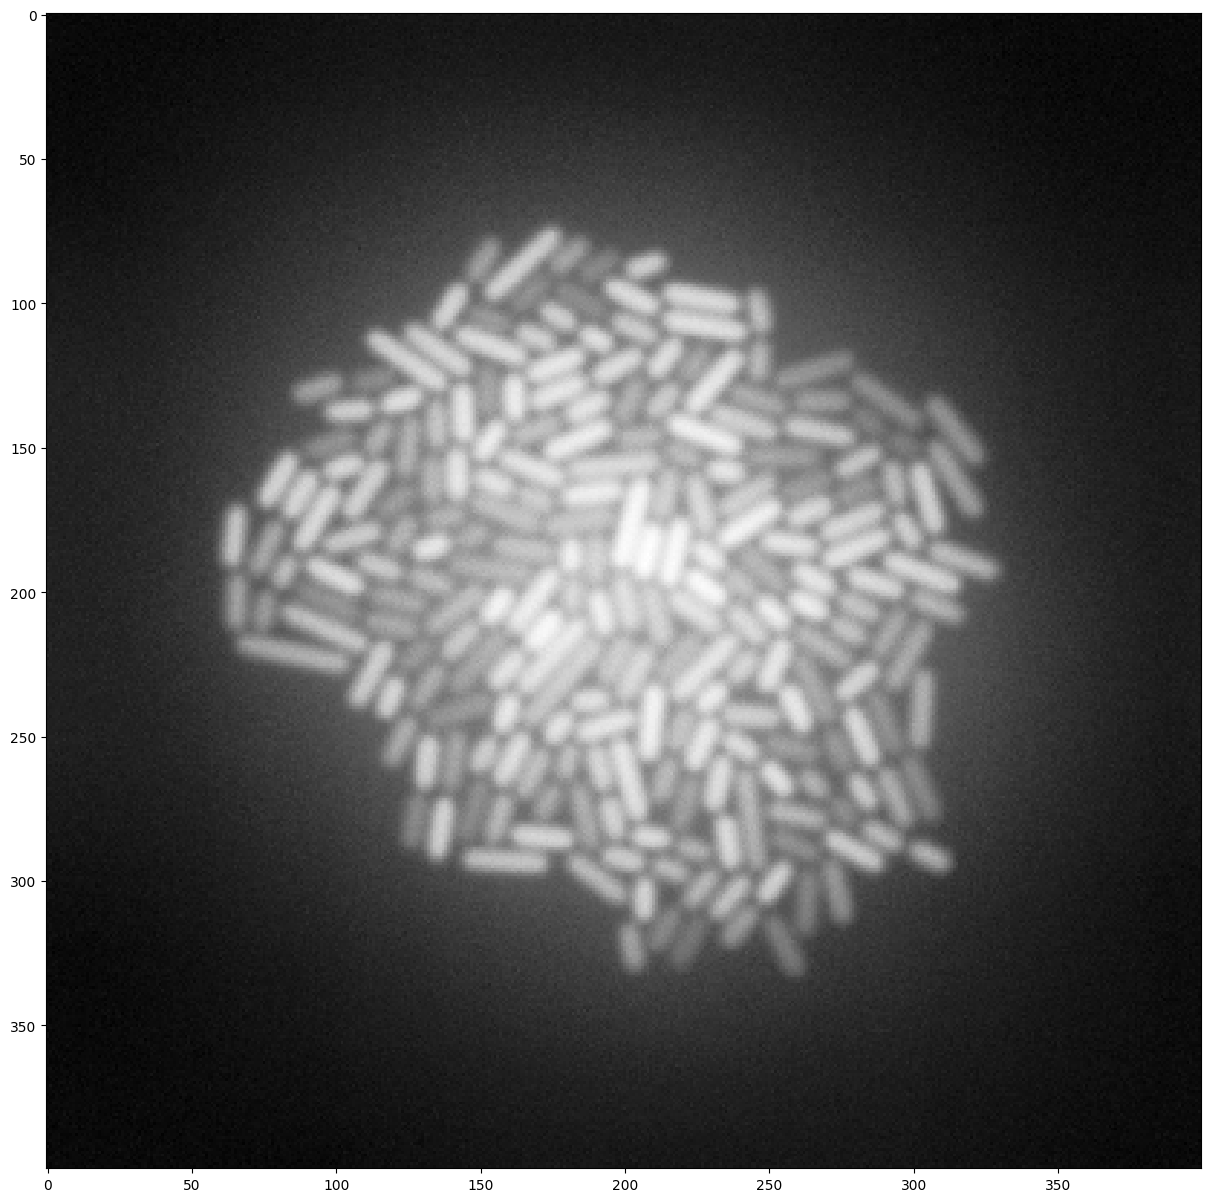

In [61]:
radius=300
#F = 5
λ = 0.75
resize_amount = 3
pix_mic_conv = 0.108379937 ##0.108379937 micron/pix for 60x, 0.0655 for 100x
scale = pix_mic_conv / resize_amount 
min_sigma = 0.42*0.6/6 / scale # micron#
sigma=min_sigma
NA=0.9
n = 1
temp_kernel = get_fluorescence_kernel(λ, NA, n, radius, scale)[0]
temp_kernel += 0.001#np.random.uniform(0,0.001) #0.0000002 #max = 0.0000002 min = 0.0000001
temp_kernel =(gaussian_filter(temp_kernel, 2, mode="reflect"))
img_idx = 2422 #np.random.randint(0,len(imgs))
scene = np.array(Image.open(imgs[img_idx]))
scene = rescale_intensity(scene, out_range=(0,1))
convolved = convolve_rescale(scene, temp_kernel, 1/resize_amount, rescale_int = True)
convolved = random_noise((convolved), mode="poisson")
convolved = random_noise((convolved), mode="gaussian", mean=1, var=0.0001, clip=False)
convolved = rescale_intensity(convolved.astype(np.float32), out_range=(0,np.iinfo(np.uint16).max)).astype(np.uint16)
mask  = np.array(Image.open(masks[img_idx]))
rescaled_mask = rescale(mask, 1/resize_amount, anti_aliasing=False, order=0)
mask_borders = find_boundaries(rescaled_mask, mode="thick", connectivity=2)
space_masks = (1 *(np.where(mask_borders, 0, rescaled_mask) > 0)).astype(np.uint8)
plt.figure(figsize=(15,15))
plt.imshow(convolved, cmap="Greys_r", interpolation="none")

In [86]:
import random
n_imgs = 5000
random.seed(43)
img_idxs = list(range(len(imgs)-1))
random.shuffle(img_idxs)
img_idxs = img_idxs * 3
img_idxs = img_idxs[:5000]


In [87]:
for i in tqdm(range(n_imgs)):
    radius=300
    λ = 0.75
    resize_amount = 3
    pix_mic_conv = 0.108379937 ##0.108379937 micron/pix for 60x, 0.0655 for 100x
    scale = pix_mic_conv / resize_amount 
    min_sigma = 0.42*0.6/6 / scale # micron#
    sigma=min_sigma
    NA=0.9
    n = 1
    temp_kernel = get_fluorescence_kernel(λ, NA, n, radius, scale)[0]
    temp_kernel += np.random.uniform(0,0.001) #0.0000002 #max = 0.0000002 min = 0.0000001
    temp_kernel =(gaussian_filter(temp_kernel, 2, mode="reflect")).astype(np.float32)
    scene = np.array(Image.open(imgs[img_idxs[i]]))
    scene = rescale_intensity(scene, out_range=(0,1)).astype(np.float32)
    convolved = convolve_rescale(scene, temp_kernel, 1/resize_amount, rescale_int = True)
    convolved = random_noise((convolved), mode="poisson")
    convolved = random_noise((convolved), mode="gaussian", mean=1, var=0.0001, clip=False)
    convolved = rescale_intensity(convolved.astype(np.float32), out_range=(0,np.iinfo(np.uint16).max)).astype(np.uint16)
    mask  = np.array(Image.open(masks[img_idxs[i]]))
    rescaled_mask = resize(mask, convolved.shape, preserve_range = True, order = 0).astype(np.uint16)
    space_masks = rescaled_mask
    
    if np.random.rand() > 0.25:
        n_axis_to_roll = np.random.choice([1,2])
        roll_amoint = np.random.randint(0,400)
        if n_axis_to_roll == 1:
            roll_axis = np.random.choice([0,1])
            convolved = np.roll(convolved, roll_amoint, axis=roll_axis)
            space_masks = np.roll(space_masks, roll_amoint, axis=roll_axis)
        elif n_axis_to_roll == 2:            
            convolved = np.roll(convolved, roll_amoint, axis=(0,1))
            space_masks = np.roll(space_masks, roll_amoint, axis=(0,1))
    im = Image.fromarray(convolved.astype(np.uint16))
    im.save(f"convolutions/synth_{i}.png")
    im = Image.fromarray(space_masks.astype(np.uint8))
    im.save(f"masks/synth_{i}.png")
    #tifffile.imsave(f"100x_agar_PC_training_data/convolutions/synth_{i}.png", convolved, dtype=np.uint16)
    #tifffile.imsave(f"100x_agar_PC_training_data/masks/synth_{i}.png", space_masks, dtype=np.uint8)

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/gh464/storage/Dropbox (Cambridge University)/projection_diffraction_frontiers_in_physics/NPJ_imaging_response_to_reviewers/colony_segmentation_comparison/SyMBac-447fbbc12a466382afcce5243d03ddcaf80536dc/SyMBac/PSF.py:32: RuntimeWarning: invalid value encountered in divide
  PSF = (2*jv(1,rr)/(rr))**2


In [88]:
len(imgs)

2423